In [60]:
# Standard Imports
import importlib
import os
import numpy as np
import pandas as pd
import sys

# Arima modelling
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import kpss

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Src modules
sys.path.append(os.path.dirname(os.getcwd())) # Add the parent directory to the Python path so we can import src modules
import src
from src.arima import arima_trial, visualise_autocorrelation
from src.data_setup import get_data, train_val_split, create_day_of_week, RAW_PATH, RESULTS_PATH
from src.model_evaluation import model_eval_pipeline, eval_hypothesis_test
from src.visualisation import plot_heatmap, plot_sales_by, plot_time_series_preds, plot_rolling_average_stdev

In [ ]:
importlib.reload(src.arima)   # Reload the src library so you dont have to restart the kernel and still get the changes

# 1. Data Loading and Processing

In [3]:
# load in dataframes
train, test, stores, transactions = get_data()

loading pickled dataframes...


In [4]:
# merge stores data into train
train = train.merge(stores, on ='store_nbr')
assert train.isnull().sum().sum() == 0
print('no null values in the training data')
assert train.duplicated().any() == False
print('no duplicate values in the training data')

no null values in the training data
no duplicate values in the training data


# 2. Data Testing and Preparation before ARIMA

Before running an ARIMA model, one must run certain tests to ensure the data is autocorrelated and stationary, in adition to preparing it for the model. 

**Resources:**
 * [TDS - Time series Forecasting — ARIMA models](https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06)

In [5]:
# this arima model will be looking at daily sales so we have to aggregate away from store number and family
daily_sales = train.groupby('date')['sales'].sum().reset_index()
print(len(daily_sales))
daily_sales.head()

1684


,date,sales
0,2013-01-01,2511.618896
1,2013-01-02,496092.406250
2,2013-01-03,361461.218750
3,2013-01-04,354459.687500
4,2013-01-05,477350.125000


## Autocorrelation
Auto-Correlation Function(ACF) - Correlation between the original data and the same data lagged by ‘h’ time period

Normally in an ARIMA model, we make use of either the AR term or the MA term. We use both of these terms only on rare occasions. We use the ACF plot to decide which one of these terms we would use for our time series

If there is a Positive autocorrelation at lag 1 then we use the AR model

If there is a Negative autocorrelation at lag 1 then we use the MA model

In [6]:
# lag of one
sales_series = daily_sales['sales']
print(f'Autocorrelation at a lag of 1: {sales_series.autocorr():.4f}')

Autocorrelation at a lag of 1: 0.7669


because the autocorr coefficient is positive for lag 1 we will use an autoregressive model.  

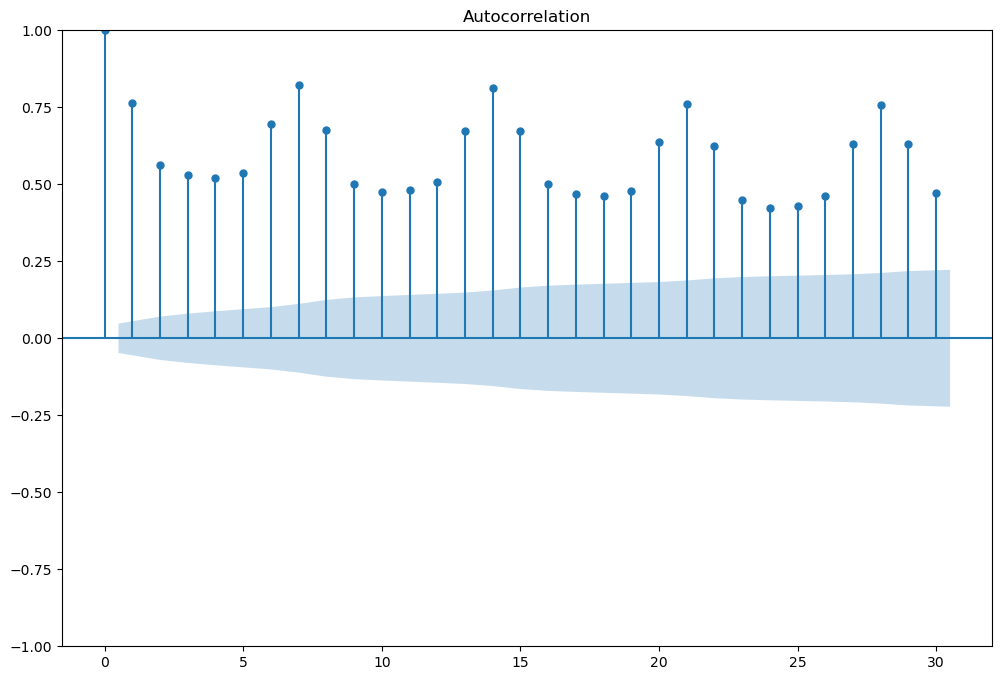

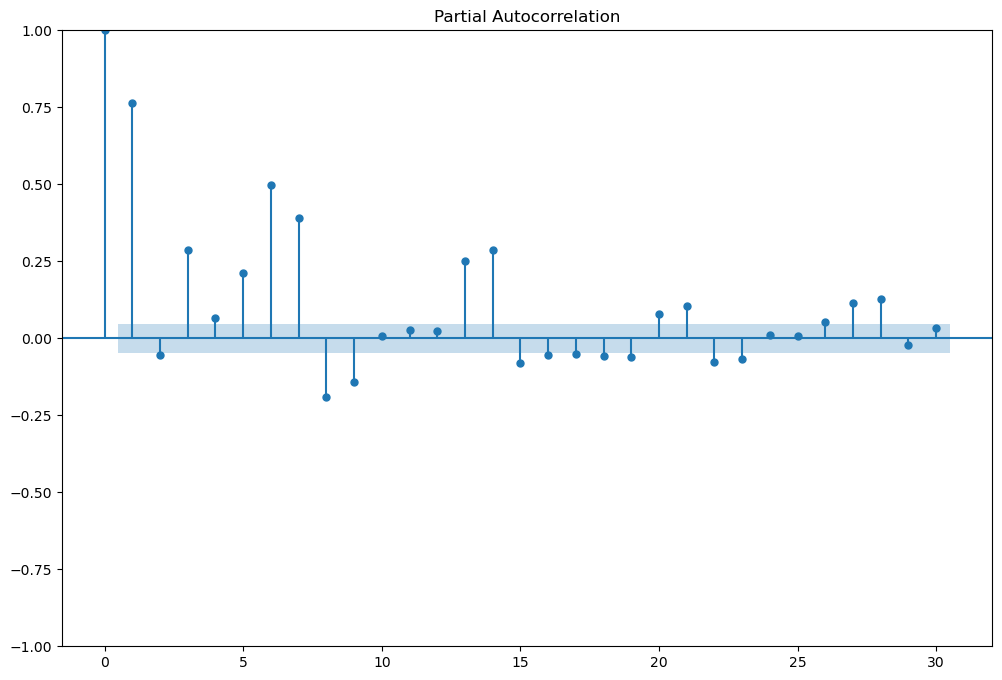

In [7]:
my_plot_size = (12, 8)
# plot acf and pcf
fig, ax = plt.subplots(figsize=my_plot_size)
acf = plot_acf(sales_series, lags=30, ax=ax)
fig, ax = plt.subplots(figsize=my_plot_size)
pacf = plot_pacf(sales_series, lags=30, method='ywm', ax=ax)   # added method to get rid of a future warning

## Stationarity Test

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast. 

Stationary time series is when the mean and variance are constant over time. It is easier to predict when the series is stationary.

Differencing is a method of transforming a non-stationary time series into a stationary one. This is an important step in preparing data to be used in an ARIMA model.

H0: the data is not stationary (mean and variance are not constant over time)
H1: the data is stationary (mean and variance are constant over time)

In [8]:
# visualise the rolling average and standard deviation of the daily sales
plot_rolling_average_stdev(daily_sales)

In [9]:
df_hypotheses = [
    'data is not stationary',   # null hypothesis
    'data is stationary'        # alternate hypothesis
]
# Dickey-Fuller Test for Stationarity
dickey_fuller = adfuller(sales_series)
eval_hypothesis_test(df_hypotheses, dickey_fuller[1])

Fail to reject the null hypothesis: "data is not stationary" (p-value: 0.0897)


Since we fail to reject the null hypothesis, we perform differencing until the data is stationary

In [10]:
daily_sales['diff_sales'] = daily_sales['sales'].diff()
daily_sales = daily_sales.dropna()

In [61]:
tmp = daily_sales.copy()
tmp['rolling_average'] = ['diff_sales'].rolling(7).mean()
px.line(data=daily_sales, x='date', y='rolling_average')

In [11]:
plot_rolling_average_stdev(daily_sales, col='diff_sales')

The rolling agerage and standard deviation are visually more constant now

In [12]:
dickey_fuller = adfuller(daily_sales['diff_sales'])
eval_hypothesis_test(df_hypotheses, dickey_fuller[1])

Reject the null hypothesis, accept alternate hypothesis: "data is stationary" (p-value: 0.0000)


The data is now stationary so we can proceed with the modelling. First lets review the autocorrelation plots on the differenced data. 

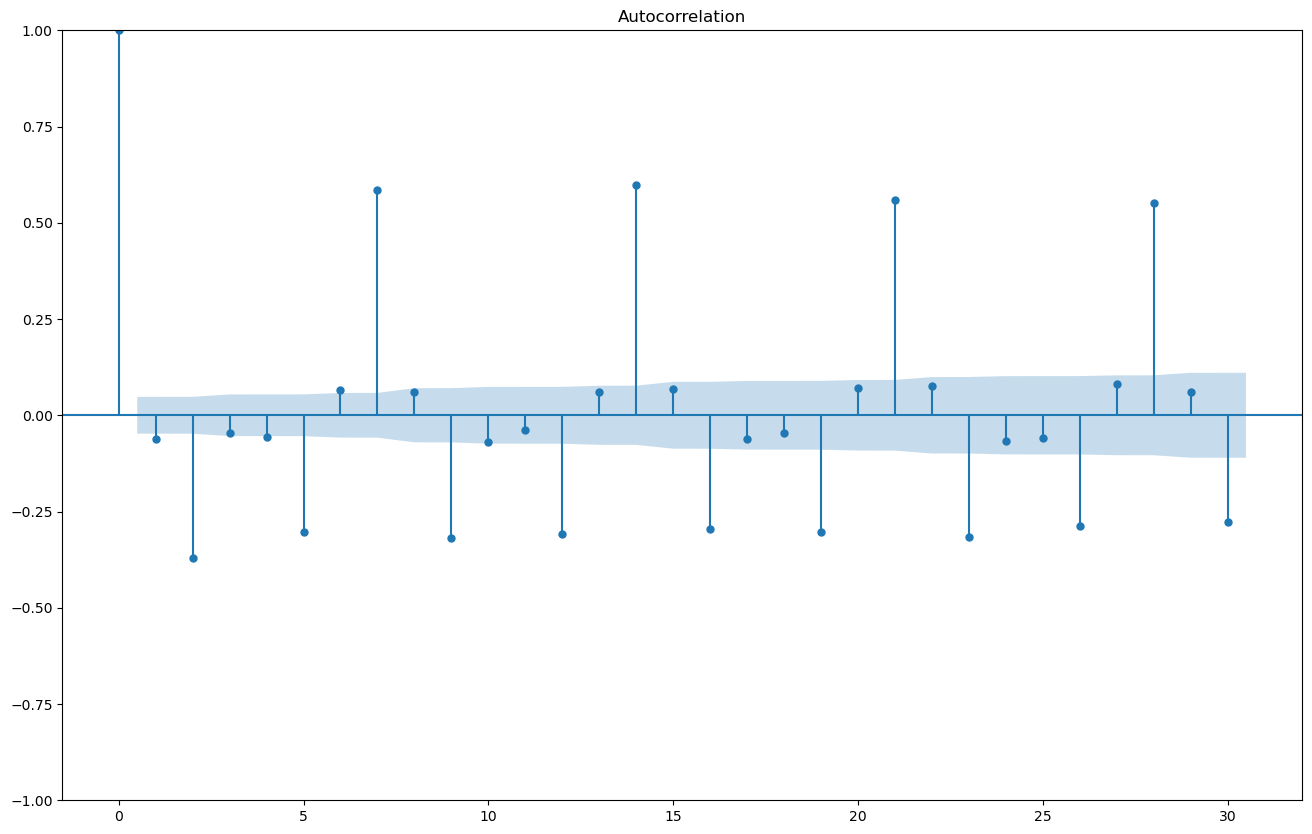

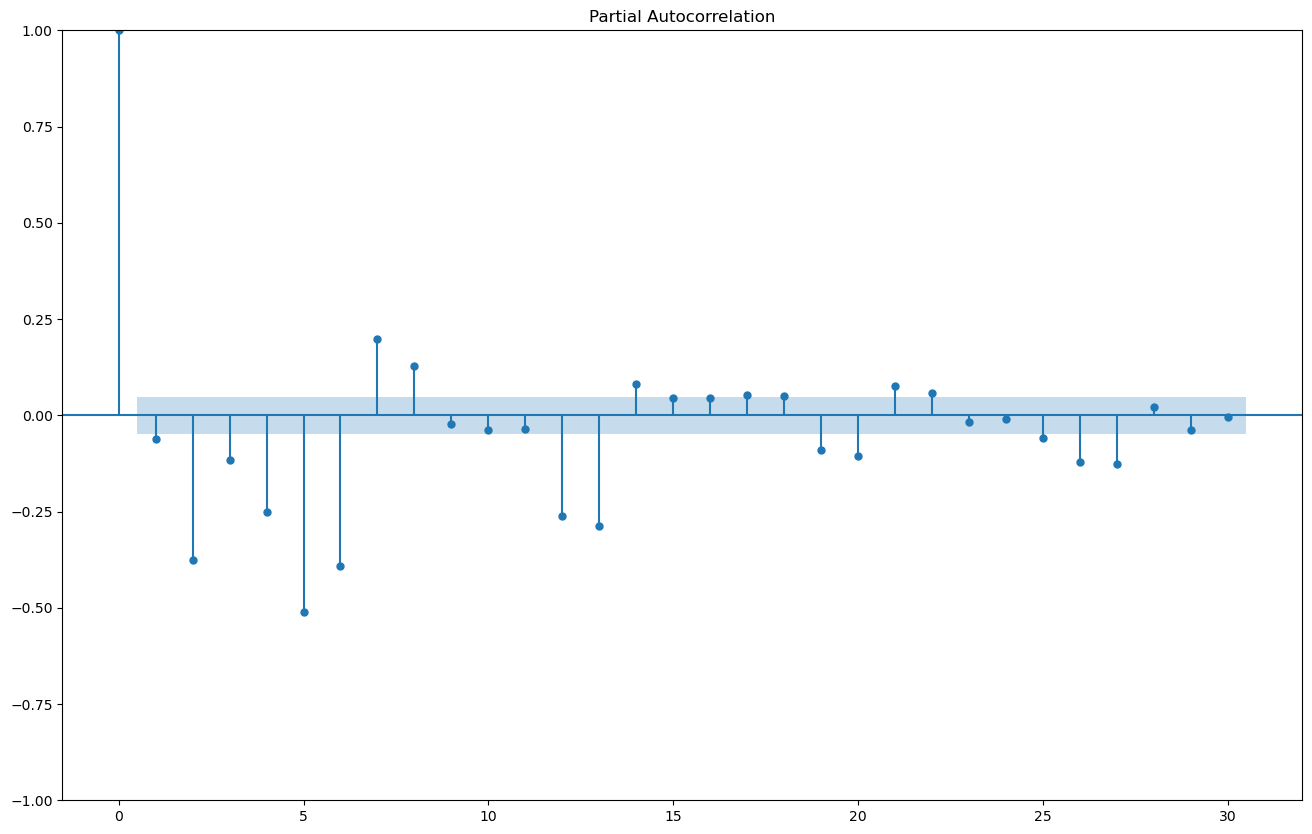

In [13]:
fig, ax = plt.subplots(figsize=(16, 10))
acf = plot_acf(daily_sales['diff_sales'], lags=30, ax=ax)
fig, ax = plt.subplots(figsize=(16, 10))
pacf = plot_pacf(daily_sales['diff_sales'], lags=30, method='ywm', ax=ax)   # added method to get rid of a future warning

Autocorrelation has peaks every 7 days, which makes sense that the data would have a weekly trend. 

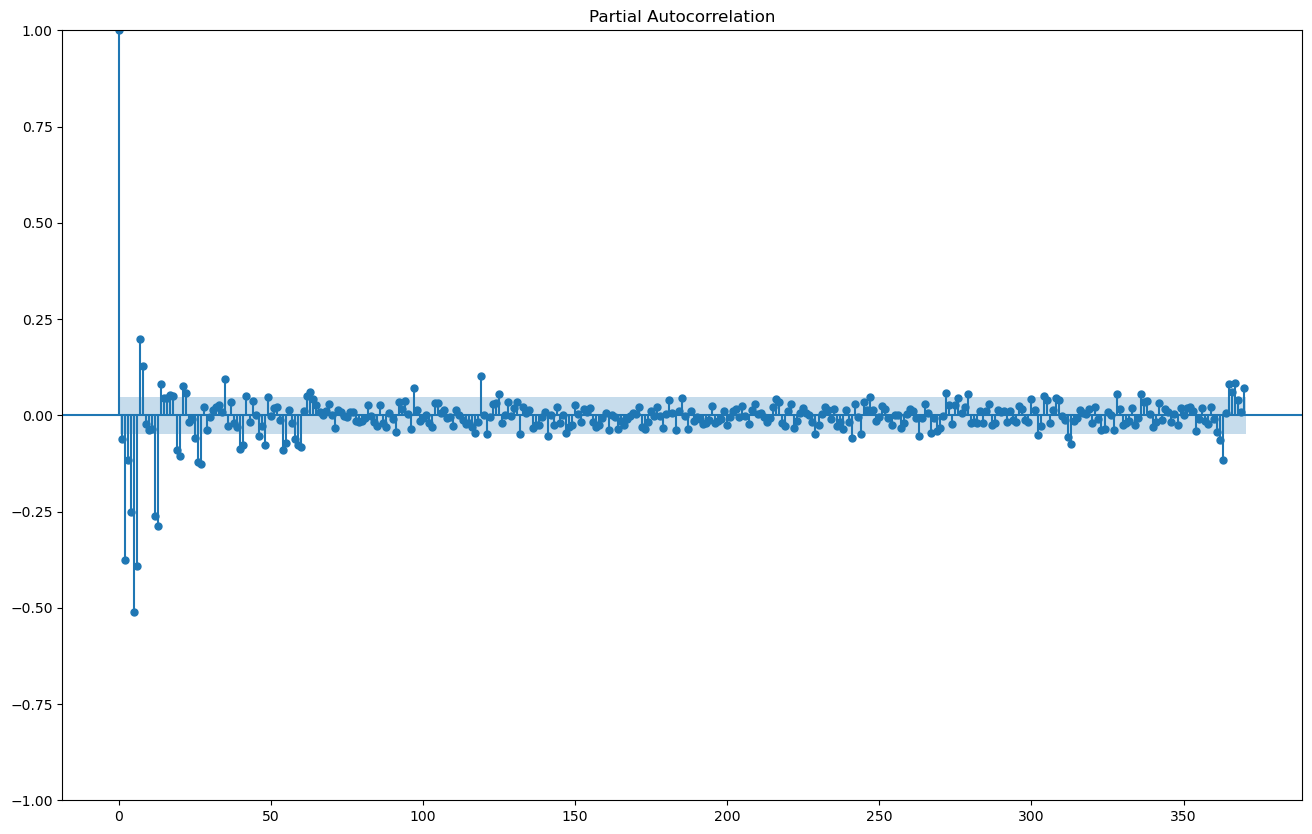

In [14]:

acf = plot_acf(daily_sales['diff_sales'], lags=370, ax=ax)
fig, ax = plt.subplots(figsize=(16, 10))
pacf = plot_pacf(daily_sales['diff_sales'], lags=370, method='ywm', ax=ax,title='Partial Autocorrelation')   # added method to get rid of a future warning

# Building the ARIMA Model

In [15]:
# split into train and validation data
train_daily_sales, valid_daily_sales = train_val_split(daily_sales)
(train_daily_sales.shape, valid_daily_sales.shape)

((1654, 3), (29, 3))

In [16]:
X_train = train_daily_sales['diff_sales'].values   # pass the differenced sales numbers to the arima model
X_valid = valid_daily_sales['diff_sales'].values
X_train.shape

(1654,)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1654
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -22666.562
Date:                Sun, 18 Jun 2023   AIC                          45337.124
Time:                        13:55:24   BIC                          45347.945
Sample:                             0   HQIC                         45341.136
                               - 1654                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3554      0.012    -30.219      0.000      -0.378      -0.332
sigma2      4.754e+10   1.11e-13   4.27e+23      0.000    4.75e+10    4.75e+10
Ljung-Box (L1) (Q):                  47.89   Jarque-

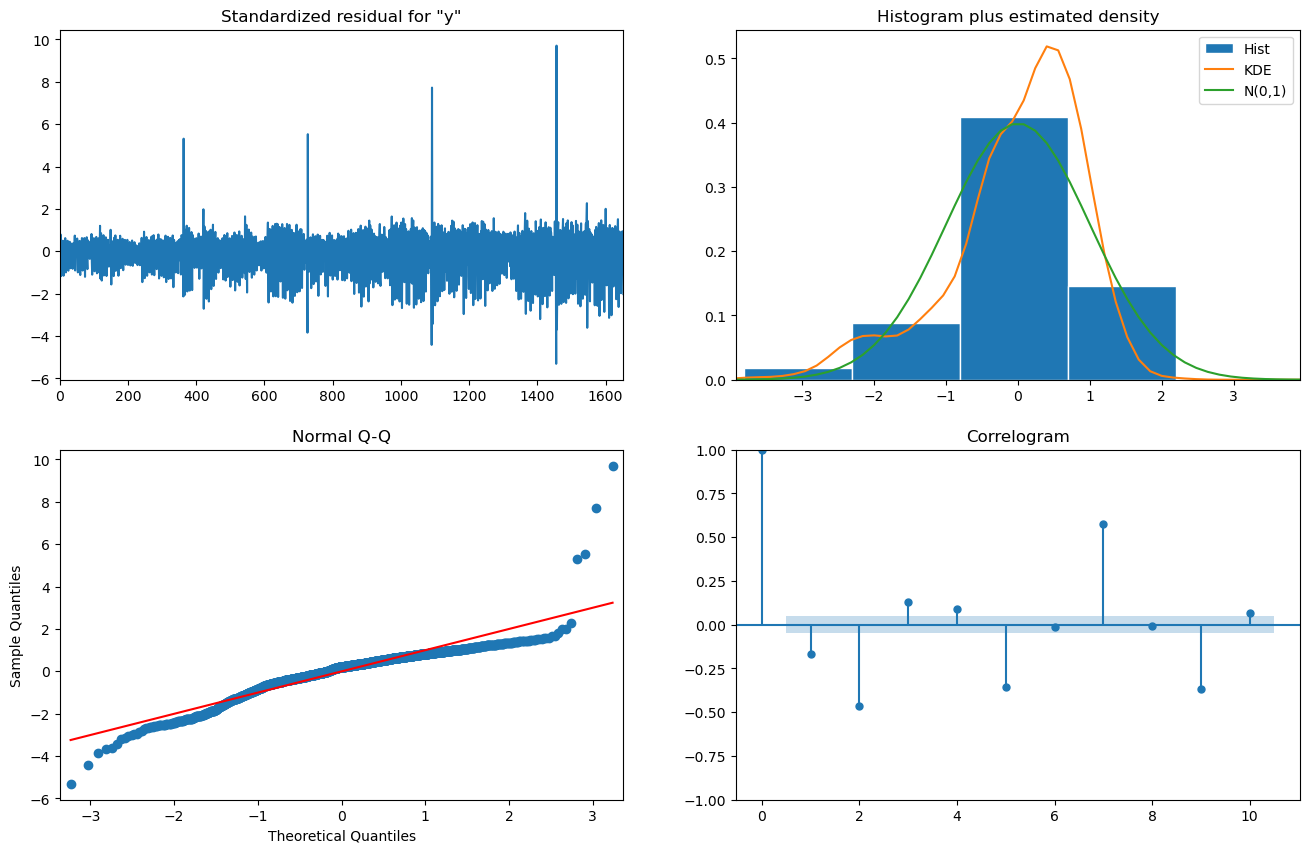

In [17]:
valid_result = arima_trial(X_train, X_valid, pdq_order=(1, 1, 0), plots=True, date_series=train_daily_sales['date'], show_summary=True)

### Seasonal ARIMA

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1654
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -21639.461
Date:                           Sun, 18 Jun 2023   AIC                          43288.923
Time:                                   13:55:26   BIC                          43315.953
Sample:                                        0   HQIC                         43298.946
                                          - 1654                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2971      0.021    -14.189      0.000      -0.338      -0.256
ma.L1         -0.9986      0.023    -42.607

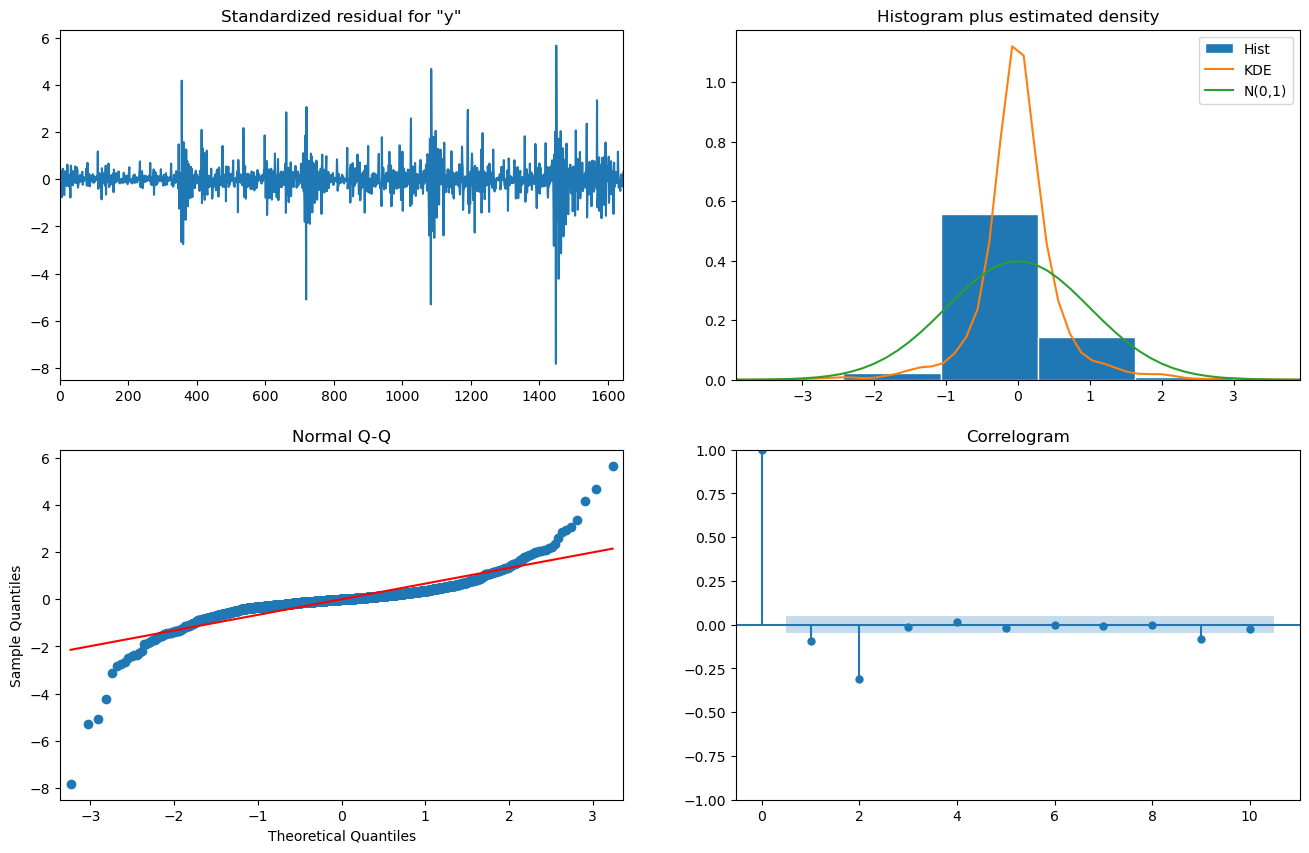

In [18]:
valid_result = arima_trial(X_train, X_valid, pdq_order=(1, 1, 1), seasonal_order=(1, 1, 1, 7), plots=True, date_series=train_daily_sales['date'], show_summary=True)

# Decompose daily sales into sales by store and family

## Decomposing daily sales by weekday, store, and family

In [ ]:
# Turn differenced sales into actual sales

# def get_actual_sales_from_diff(df: pd.DataFrame, start_value: float) -> pd.DataFrame:

# Retrieve the last value of the original series
last_original_value = train_daily_sales['sales'].iloc[-1]

# Reverse the differencing and obtain actual predictions
valid_result['pred_sales'] = (valid_result['pred_diff_sales'].cumsum() + last_original_value)

# add day of week feature
valid_result['day_of_week'] = create_day_of_week(valid_result.date)

valid_result.to_pickle(RESULTS_PATH / 'arima_validation_results_20230613_from_function.pkl')
valid_result

,date,diff_sales,pred_diff_sales,pred_sales,day_of_week
0,2017-07-18,-88191.8125,-79305.171919,7.390203e+05,2
1,2017-07-19,37845.0625,31470.741013,7.704911e+05,3
2,2017-07-20,-79690.6875,-133150.255579,6.373408e+05,4
3,2017-07-21,94130.2500,146183.961256,7.835248e+05,5
4,2017-07-22,150483.7500,236678.162421,1.020203e+06,6
5,2017-07-23,91386.6875,96954.648285,1.117158e+06,7
6,2017-07-24,-207724.4375,-311569.622012,8.055880e+05,1
7,2017-07-25,-102982.6875,-70625.114676,7.349628e+05,2
8,2017-07-26,27071.4375,28274.510687,7.632374e+05,3
9,2017-07-27,-80803.2500,-131729.591094,6.315078e+05,4


In [ ]:
plot_time_series_preds(valid_daily_sales['date'], preds=[valid_daily_sales['sales'], valid_result['pred_sales']], col='Sales')

In [ ]:
sales_by_store_family_day_of_week = train.groupby(['store_nbr', 'family', 'day_of_week']).sales.sum().reset_index()
sales_by_store_family_day_of_week['sales'] = sales_by_store_family_day_of_week['sales'].astype('float64')
sales_by_store_family_day_of_week['pct_sales'] = sales_by_store_family_day_of_week['sales'] / sales_by_store_family_day_of_week.groupby('day_of_week')['sales'].transform('sum')
sales_by_store_family_day_of_week = sales_by_store_family_day_of_week.drop(columns=['sales'])

In [ ]:
sales_by_store_family_day_of_week.sort_values('pct_sales', ascending=False).head(20)

,store_nbr,family,day_of_week,pct_sales
10254,45,GROCERY I,7,0.016851
10716,47,GROCERY I,7,0.016226
10022,44,GROCERY I,6,0.016179
10023,44,GROCERY I,7,0.016173
10485,46,GROCERY I,7,0.016134
10253,45,GROCERY I,6,0.015668
10248,45,GROCERY I,1,0.015572
10252,45,GROCERY I,5,0.015397
10947,48,GROCERY I,7,0.015389
10484,46,GROCERY I,6,0.015206


In [ ]:
# dimension checking
dim_check = 1
for col in ['store_nbr', 'family']:
    count_unique = sales_by_store_family_day_of_week[col].nunique()
    print(col, count_unique)
    dim_check *= count_unique

print(f'num days: {len(valid_result)}')
dim_check *= len(valid_result)

print(f'Target dimension = {dim_check}')

store_nbr 54
family 33
num days: 29
Target dimension = 51678


In [ ]:
valid_store_family_sales = pd.merge(valid_result, sales_by_store_family_day_of_week, on='day_of_week')
# ensure the dimension is what was expected
assert dim_check == valid_store_family_sales.shape[0]
# ensure the groupby sums to 1 for each date
assert all(valid_store_family_sales.groupby('date').pct_sales.sum() == 1.0)
valid_store_family_sales.head(10)

,date,diff_sales,pred_diff_sales,pred_sales,day_of_week,store_nbr,family,pct_sales
0,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,AUTOMOTIVE,6.793689e-06
1,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,BABY CARE,0.000000e+00
2,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,BEAUTY,4.546044e-06
3,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,BEVERAGES,2.897715e-03
4,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,BOOKS,2.537664e-07
5,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,BREAD/BAKERY,6.141791e-04
6,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,CELEBRATION,1.685734e-05
7,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,CLEANING,1.222328e-03
8,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,DAIRY,1.134517e-03
9,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,DELI,2.247155e-04


In [ ]:
valid_store_family_sales['pred_decomposed_sales'] = valid_store_family_sales['pct_sales'] * valid_store_family_sales['pred_sales']

In [ ]:
valid_store_family_sales.head(10)

,date,diff_sales,pred_diff_sales,pred_sales,day_of_week,store_nbr,family,pct_sales,pred_decomposed_sales
0,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,AUTOMOTIVE,6.793689e-06,5.020675
1,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,BABY CARE,0.000000e+00,0.000000
2,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,BEAUTY,4.546044e-06,3.359619
3,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,BEVERAGES,2.897715e-03,2141.470421
4,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,BOOKS,2.537664e-07,0.187539
5,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,BREAD/BAKERY,6.141791e-04,453.890817
6,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,CELEBRATION,1.685734e-05,12.457917
7,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,CLEANING,1.222328e-03,903.324915
8,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,DAIRY,1.134517e-03,838.431223
9,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,DELI,2.247155e-04,166.069342


In [ ]:
_, val = train_val_split()

loading pickled dataframes...


In [ ]:
val['sales']

id
2949210       3.000000
2949211       0.000000
2949212       3.000000
2949213    2589.000000
2949214       0.000000
              ...     
3000883     438.132996
3000884     154.552994
3000885    2419.729004
3000886     121.000000
3000887      16.000000
Name: sales, Length: 51678, dtype: float32

In [ ]:
valid_store_family_sales['actual_sales'] = val['sales'].values

In [ ]:
valid_store_family_sales.head()

,date,diff_sales,pred_diff_sales,pred_sales,day_of_week,store_nbr,family,pct_sales,pred_decomposed_sales,actual_sales
0,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,AUTOMOTIVE,6.793689e-06,5.020675,3.0
1,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,BABY CARE,0.000000e+00,0.000000,0.0
2,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,BEAUTY,4.546044e-06,3.359619,3.0
3,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,BEVERAGES,2.897715e-03,2141.470421,2589.0
4,2017-07-18,-88191.8125,-79305.171919,739020.328081,2,1,BOOKS,2.537664e-07,0.187539,0.0


In [ ]:
model_eval_pipeline(valid_store_family_sales['actual_sales'], valid_store_family_sales['pred_decomposed_sales'])

{'mae': 340.73995080722017,
 'mse': 1106030.7232993948,
 'rmse': 1051.6799528846193,
 'rmsle': 1.1732315546698482,
 'r2': 0.3075665083835968}

## EDA, what features matter in determining how to allocate daily sales?

In [19]:
for col in ['store_nbr', 'family', 'day_of_week']:
    plot_sales_by(train, col)

In [20]:
# Plot daily sales by year and day of the week
grouped = train.groupby(['year', 'day_of_week'])['sales'].mean().reset_index()

# Create a line chart
fig = px.line(grouped, x="day_of_week", y="sales" , color="year", title="Average sales by year and day_of_week")
# Set xticks
fig.update_layout(
    xaxis=dict(
        tickvals=list(range(1, 8)),  # Specify tick values
        ticktext=['mon', 'tues', 'weds', 'thurs', 'fri', 'sat', 'sun']  # Specify tick labels
    )
)
# Show the chart
fig.show()

The data exhibits a trend by day of the week

In [21]:
# Plot daily sales by month and day of the week
grouped = train.groupby(['month', 'day_of_week'])['sales'].mean().reset_index()

# Create a line chart
fig = px.line(grouped, x="day_of_week", y="sales" , color="month", title="Average sales by month and day_of_week")

# Set xticks
fig.update_layout(
    xaxis=dict(
        tickvals=list(range(1, 8)),  # Specify tick values
        ticktext=['mon', 'tues', 'weds', 'thurs', 'fri', 'sat', 'sun']  # Specify tick labels
    )
)
# Show the chart
fig.show()

Within any given month, the same weekly trend appears to hold true.

In [22]:
# plot a heatmap to see how the families behave on different days of the week
plot_heatmap(train, 'family', 'day_of_week')

In [23]:
# plot a heatmap to see how the families behave on different months
plot_heatmap(train, 'family', 'month')

In [24]:
plot_heatmap(train, 'store_nbr', 'month')

In [25]:
plot_heatmap(train, 'store_nbr', 'day_of_week')

In [26]:
plot_heatmap(train, 'family', 'store_nbr')

In [27]:
plot_heatmap(train, 'store_nbr', 'family')

In [28]:
plot_heatmap(train, 'family', 'store_nbr')